<a href="https://colab.research.google.com/github/hirotakasaito/dl_study/blob/main/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch #pytorchをインポート
import torch.nn as nn #損失関数や全結合層などの関数やクラスが定義されている
import torch.nn.functional as F
from torchvision import datasets, transforms #学習データの前処理

Epoch: 1/100 
 Generator_loss: 0.6239442937274879 
 Disriminator_loss: 1.0368506432597386
Epoch: 2/100 
 Generator_loss: 0.6437881453441836 
 Disriminator_loss: 1.0130624353822038
Epoch: 3/100 
 Generator_loss: 0.6240446076449107 
 Disriminator_loss: 1.05559722998099
Epoch: 4/100 
 Generator_loss: 0.6107761378985459 
 Disriminator_loss: 1.1050776559998665
Epoch: 5/100 
 Generator_loss: 0.6087328606506803 
 Disriminator_loss: 1.1449173934431698
Epoch: 6/100 
 Generator_loss: 0.6067267125800427 
 Disriminator_loss: 1.1683550237209845
Epoch: 7/100 
 Generator_loss: 0.6134581672725453 
 Disriminator_loss: 1.175611237451641
Epoch: 8/100 
 Generator_loss: 0.6183345961596185 
 Disriminator_loss: 1.1807307647411953
Epoch: 9/100 
 Generator_loss: 0.6227005314292623 
 Disriminator_loss: 1.1836901555829775
Epoch: 10/100 
 Generator_loss: 0.625594587946905 
 Disriminator_loss: 1.1826906641875667
Epoch: 11/100 
 Generator_loss: 0.6301496214647813 
 Disriminator_loss: 1.1841684054412354
Epoch: 12/10

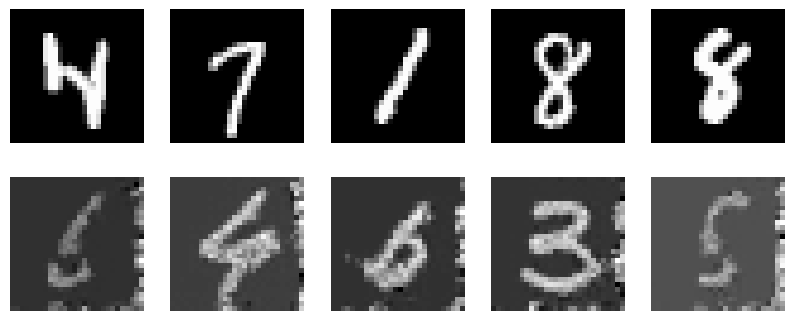

In [15]:
#DCGANを用いたMNIST生成モデル

%matplotlib inline
import matplotlib.pyplot as plt

#----------------------------------------------------------
# ハイパーパラメータなどの設定値
num_epochs = 100         # 学習を繰り返す回数
num_batch = 64         # 一度に処理する画像の枚数
z_size = 100           #ノイズサイズ
feature_maps = 8
learning_rate = 0.001   # 学習率
image_size = 28*28      # 画像の画素数(幅x高さ)

# GPU(CUDA)が使えるかどうか？
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#----------------------------------------------------------
# 学習用／評価用のデータセットの作成

# 変換方法の指定
transform = transforms.Compose([
    transforms.ToTensor()
    ])

# MNISTデータの取得
# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
# 学習用
train_dataset = datasets.MNIST(
    './data',               # データの保存先
    train = True,           # 学習用データを取得する
    download = True,        # データが無い時にダウンロードする
    transform = transform   # テンソルへの変換など
    )
# 評価用
test_dataset = datasets.MNIST(
    './data',
    train = False,
    transform = transform
    )

# データローダー
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = num_batch,
    drop_last=True,
    shuffle = True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = num_batch,
    drop_last=True,
    shuffle = True)

#----------------------------------------------------------
# ニューラルネットワークモデルの定義
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        # 各クラスのインスタンス（入出力サイズなどの設定）
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 5, 2, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, 5, 2, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 順伝播の設定（インスタンスしたクラスの特殊メソッド(__call__)を実行）
        x = self.conv(x)
        x = x.reshape(64,-1)
        return x

class Generator(nn.Module):
    def __init__(self, zsize, feature_maps):
        super(Generator, self).__init__()

        # 各クラスのインスタンス（入出力サイズなどの設定）
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(zsize, feature_maps * 8, 4, 1, 0, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps * 2, 1, 2, 2, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # 順伝播の設定（インスタンスしたクラスの特殊メソッド(__call__)を実行）
        x = self.deconv(x)
        return x

#----------------------------------------------------------
# ニューラルネットワークの生成
generator_model = Generator(z_size, feature_maps).to(device)
discriminator_model = Discriminator(image_size).to(device)

#----------------------------------------------------------
# 損失関数の設定
criterion = nn.BCELoss()
#----------------------------------------------------------
# 最適化手法の設定

one_labels = torch.ones(num_batch).to(device)
zero_labels = torch.zeros(num_batch).to(device)

optimizer_netD = torch.optim.Adam(discriminator_model.parameters(), lr=0.0002, betas=[0.5, 0.999])
optimizer_netG = torch.optim.Adam(generator_model.parameters(), lr=0.0002, betas=[0.5, 0.999])
#----------------------------------------------------------
# 学習
generator_model.train()  # モデルを訓練モードにする
discriminator_model.train()  # モデルを訓練モードにする

for epoch in range(num_epochs): # 学習を繰り返し行う
    sum_discriminator_loss = 0
    sum_generator_loss = 0

    for inputs, _ in train_dataloader:

        inputs = inputs.to(device)

        #discriminator
        #本物を本物であると識別する処理
        optimizer_netD.zero_grad()
        output_real_imgs = discriminator_model(inputs).squeeze()
        loss_real_imgs = criterion(output_real_imgs, one_labels)
        loss_real_imgs.backward()

        #偽物を偽物であると識別する処理
        z = torch.randn(num_batch, z_size, 1, 1, device=device)
        fake_imgs = generator_model(z) #偽物画像生成
        output_fake_imgs = discriminator_model(fake_imgs.detach()).squeeze()
        loss_fake_imgs = criterion(output_fake_imgs, zero_labels)
        loss_fake_imgs.backward()

        loss_discriminator = loss_real_imgs + loss_fake_imgs
        optimizer_netD.step()
        sum_discriminator_loss += loss_discriminator

        #generator
        optimizer_netG.zero_grad()
        z = torch.randn(num_batch, z_size, 1, 1, device=device)
        fake_imgs = generator_model(z)
        output_fake_imgs = discriminator_model(fake_imgs).squeeze()
        loss_generator = criterion(output_fake_imgs, one_labels)
        loss_generator.backward()
        optimizer_netG.step()
        sum_generator_loss += loss_generator

    # 学習状況の表示
    print(f"Epoch: {epoch+1}/{num_epochs} \n Generator_loss: {sum_generator_loss.item() / len(train_dataloader)} \n Disriminator_loss: {sum_discriminator_loss.item() / len(train_dataloader)}")

#----------------------------------------------------------
# 評価
generator_model.eval()  # モデルを評価モード
discriminator_model.eval()  # モデルを評価モード
loss_sum = 0
correct = 0
show_labels = [0,1,2,3,4,5,6,7,8,9]
show_img_list = []

sum_discriminator_loss = 0
sum_generator_loss = 0
count = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:

        inputs = inputs.to(device)
        #discriminator
        #本物を本物であると識別する処理
        output_real_imgs = discriminator_model(inputs).squeeze()
        loss_real_imgs = criterion(output_real_imgs, one_labels)

        #偽物を偽物であると識別する処理
        z = torch.randn(num_batch, z_size, 1, 1, device=device)
        fake_imgs = generator_model(z) #偽物画像生成
        output_fake_imgs = discriminator_model(fake_imgs.detach()).squeeze()
        loss_fake_imgs = criterion(output_fake_imgs, zero_labels)

        loss_discriminator = loss_real_imgs + loss_fake_imgs
        sum_discriminator_loss += loss_discriminator

        #generator
        z = torch.randn(num_batch, z_size, 1, 1, device=device)
        fake_imgs = generator_model(z)
        output_fake_imgs = discriminator_model(fake_imgs).squeeze()
        loss_generator = criterion(output_fake_imgs, one_labels)
        sum_generator_loss += loss_generator

        fake_imgs = fake_imgs.reshape(num_batch, 28, 28)
        inputs = inputs.reshape(num_batch, 28, 28)
        for fake_img, real_img in zip(fake_imgs, inputs):
            if count < 5:
                fake_img = fake_img.squeeze().to('cpu').detach().numpy().copy()
                real_img = real_img.squeeze().to('cpu').detach().numpy().copy()
                show_img_list.append((fake_img, real_img))
            count += 1

    print(f"Eval \n Generator_loss: {sum_generator_loss.item() / len(test_dataloader)} \n Disriminator_loss: {sum_discriminator_loss.item() / len(test_dataloader)}")

print("======================= Visualize image =======================")
fig = plt.figure(figsize=(10,8))
for idx, v in enumerate(show_img_list):
    ax_real = fig.add_subplot(1, 5, idx+1)
    ax_fake = fig.add_subplot(2, 5, idx+1)
    ax_real.imshow(v[0],cmap="gray")
    ax_fake.imshow(v[1],cmap="gray")
    ax_real.axis("off")
    ax_fake.axis("off")
plt.show()